In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm

In [2]:
url = "https://www.flightconnections.com/flights-to-singapore-sin"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    
    airport_names = []
    airport_codes = []
    countries = []
    total_flights = []
    
    destinations = soup.find_all('a', class_='popular-destination') 
    for destination in destinations:
        data_a = destination.get('data-a', '')
        if '(' in data_a and ')' in data_a:
            name, code = data_a.rsplit('(', 1)
            airport_names.append(name.strip())
            airport_codes.append(code.strip(')'))
        else:
            airport_names.append('')
            airport_codes.append('')
    
        img_tag = destination.find('img', title=True)
        country = img_tag['title'] if img_tag else ''
        countries.append(country)

        flights_span = destination.find('span', class_='float-right')
        flights_text = flights_span.get_text(strip=True) if flights_span else ''
        total = ''.join(filter(str.isdigit, flights_text))
        total_flights.append(total)
    
    flights_df = pd.DataFrame({
        'airport_name': airport_names,
        'airport_code': airport_codes,
        'country': countries,
        'total_flights': total_flights
    })
    flights_df = flights_df[flights_df['total_flights'] != '']
    flights_df['total_flights'] = flights_df['total_flights'].astype(int)
    flights_df.to_csv('flights_to_singapore.csv', index=False)
    print("Data extracted")
else:
    print(f"Failed to fetch. Status code: {response.status_code}")


Data extracted


world map

/var/folders/py/1g3r4k5571x31fdt20r8rnj00000gn/T/ipykernel_49821/946458002.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


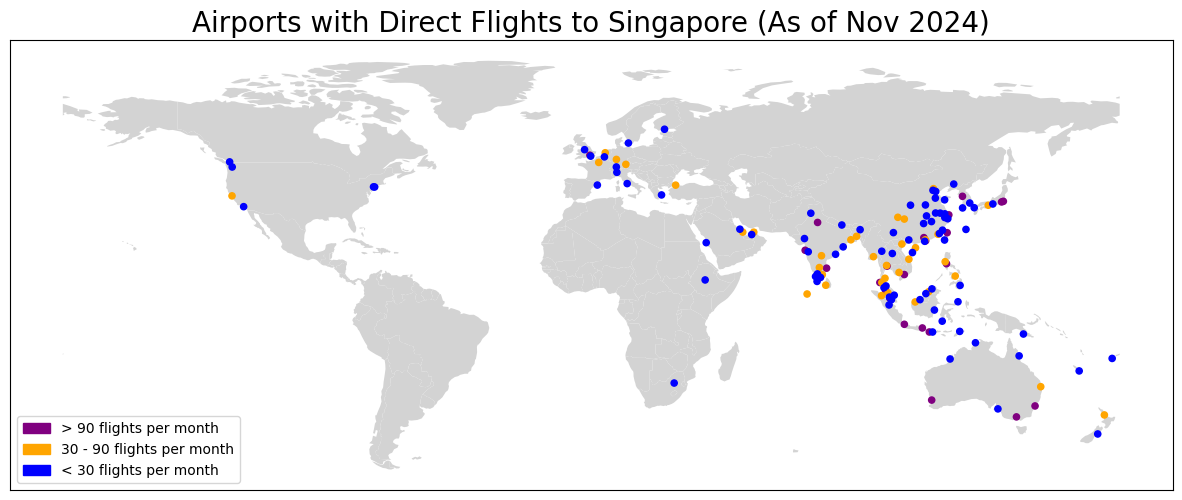

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['continent'] != 'Antarctica']

flights_df = flights_df[flights_df['total_flights'] > 0].copy()
airports_df = pd.read_excel("/Users/ciruixiang/Downloads/airports_lat_lon.xlsx")

merged_df = pd.merge(flights_df, airports_df, left_on='airport_code', right_on='iata')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf['color'] = gdf['total_flights'].apply(lambda x: 'purple' if x > 90 else ('orange' if x >= 30 else 'blue'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=20,
    legend=False
)

purple_patch = mpatches.Patch(color='purple', label='> 90 flights per month')
orange_patch = mpatches.Patch(color='orange', label='30 - 90 flights per month')
blue_patch = mpatches.Patch(color='blue', label='< 30 flights per month')
plt.legend(handles=[purple_patch, orange_patch, blue_patch], loc='lower left')

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Airports with Direct Flights to Singapore (As of Nov 2024)', fontsize=20)

plt.show()

southeast asia

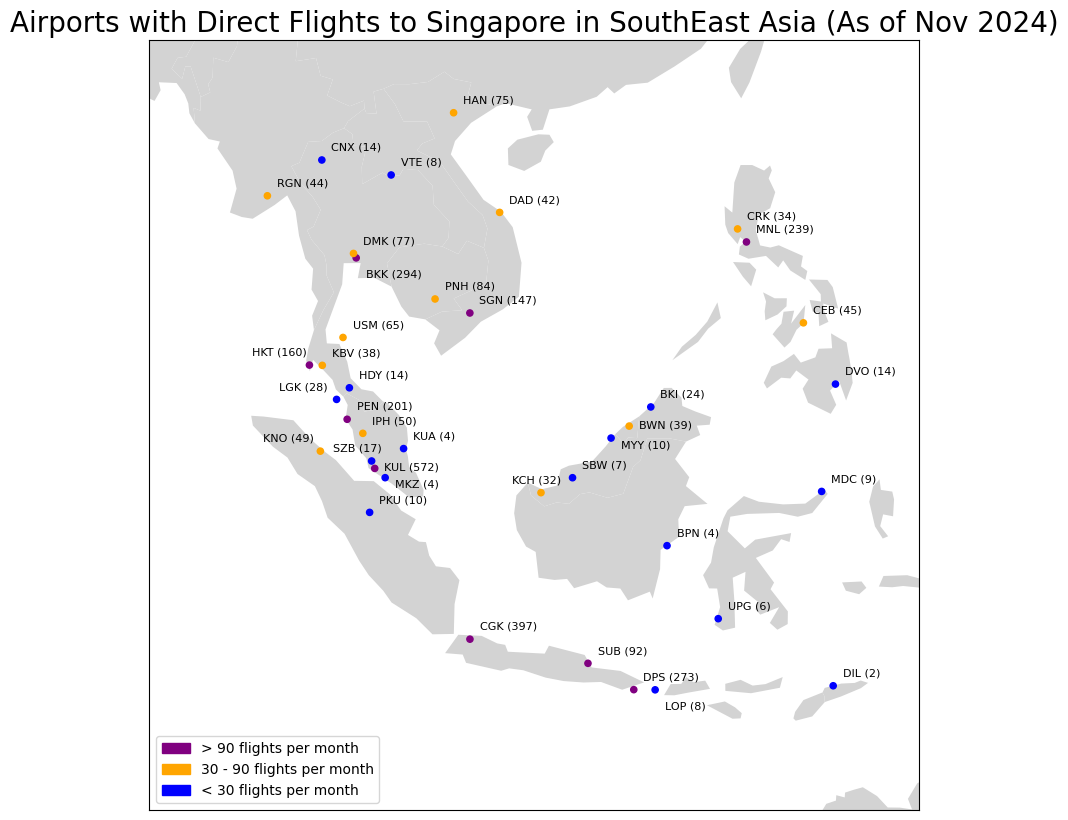

In [10]:
southeast_asian_countries = [
    'Brunei', 'Cambodia', 'Timor-Leste', 'Indonesia', 'Laos', 
    'Malaysia', 'Myanmar', 'Philippines', 'Singapore', 'Thailand', 'Vietnam'
]
flights_df_sea = flights_df[flights_df['country'].isin(southeast_asian_countries)]

merged_df = pd.merge(flights_df_sea, airports_df, left_on='airport_code', right_on='iata')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf['color'] = gdf['total_flights'].apply(lambda x: 'purple' if x > 90 else ('orange' if x >= 30 else 'blue'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=20,
    legend=False
)

purple_patch = mpatches.Patch(color='purple', label='> 90 flights per month')
orange_patch = mpatches.Patch(color='orange', label='30 - 90 flights per month')
blue_patch = mpatches.Patch(color='blue', label='< 30 flights per month')
plt.legend(handles=[purple_patch, orange_patch, blue_patch], loc='lower left')

# Add text labels for each airport
for idx, row in gdf.iterrows():
    lon_offset = 0.5
    lat_offset = 0.5
    airport_label = f"{row['airport_code']} ({row['total_flights']})"
    if row['airport_code'] == 'BKK':
        lat_offset = -1
    if row['airport_code'] == 'HKT':
        lon_offset = -3
    if row['airport_code'] == 'LGK':
        lon_offset = -3
    if row['airport_code'] == 'KNO':
        lon_offset = -3
    if row['airport_code'] == 'SZB':
        lon_offset = -2
    if row['airport_code'] == 'KUL':
        lat_offset = -0.1
    if row['airport_code'] == 'MKZ':
        lat_offset = -0.5
    if row['airport_code'] == 'LOP':
        lat_offset = -1
    if row['airport_code'] == 'KCH':
        lon_offset = -1.5
    if row['airport_code'] == 'MYY':
        lat_offset = -0.5
    if row['airport_code'] == 'BWN':
        lat_offset = -0.1
    ax.text(
        row['longitude'] + lon_offset,
        row['latitude'] + lat_offset,
        airport_label,
        fontsize=8,
        ha='left'
    )

# Set the zoom to Southeast Asia
ax.set_xlim(90, 130)
ax.set_ylim(-15, 25)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Airports with Direct Flights to Singapore in SouthEast Asia (As of Nov 2024)', fontsize=20)

plt.show()

north asia

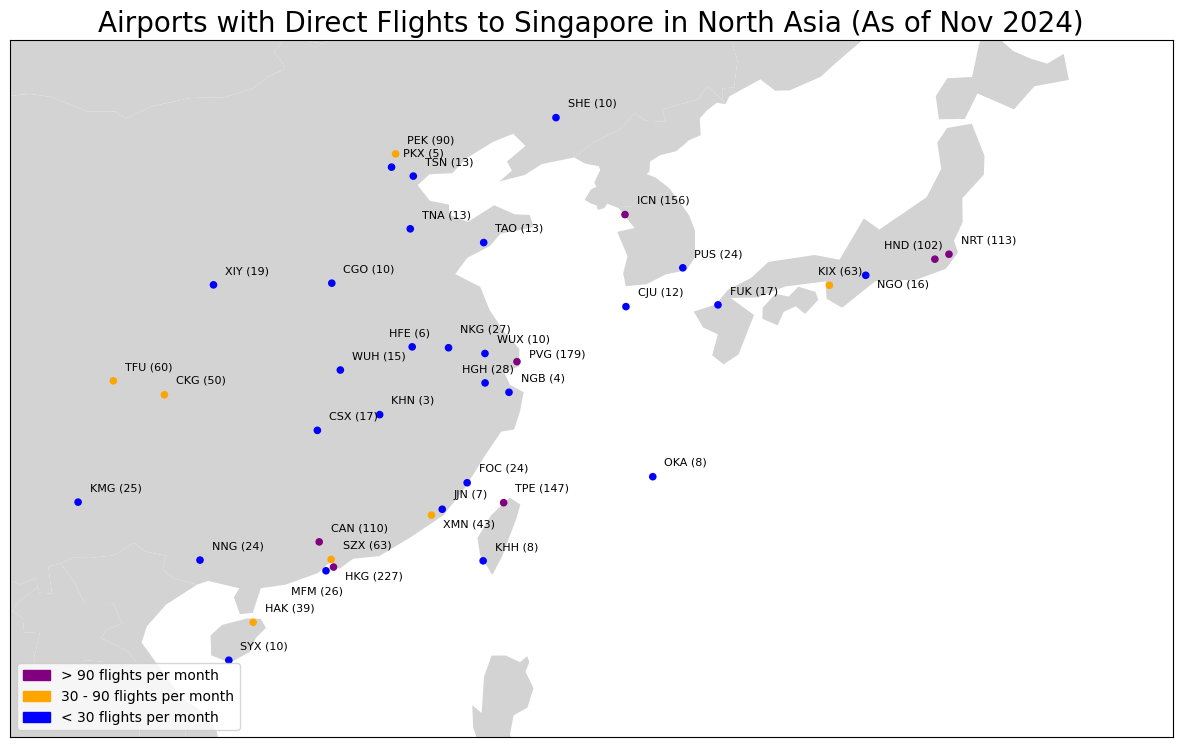

In [ ]:
north_asian_countries = [
    'China', 'Hong Kong', 'Macao', 'Taiwan', 'Japan', 'South Korea'
]
flights_df_na = flights_df[flights_df['country'].isin(north_asian_countries)]

merged_df = pd.merge(flights_df_na, airports_df, left_on='airport_code', right_on='iata')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf['color'] = gdf['total_flights'].apply(lambda x: 'purple' if x > 90 else ('orange' if x >= 30 else 'blue'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=20,
    legend=False
)

purple_patch = mpatches.Patch(color='purple', label='> 90 flights per month')
orange_patch = mpatches.Patch(color='orange', label='30 - 90 flights per month')
blue_patch = mpatches.Patch(color='blue', label='< 30 flights per month')
plt.legend(handles=[purple_patch, orange_patch, blue_patch], loc='lower left')

# Add text labels for each airport
for idx, row in gdf.iterrows():
    lon_offset = 0.5
    lat_offset = 0.5
    airport_label = f"{row['airport_code']} ({row['total_flights']})"
    if row['airport_code'] == 'HFE':
        lon_offset = -1
    if row['airport_code'] == 'NKG':
        lat_offset = 0.7
    if row['airport_code'] == 'PVG':
        lat_offset = 0.2
    if row['airport_code'] == 'HGH':
        lon_offset = -1
    if row['airport_code'] == 'XMN':
        lat_offset = -0.5
    if row['airport_code'] == 'HKG':
        lat_offset = -0.5
    if row['airport_code'] == 'MFM':
        lon_offset = -1.5
        lat_offset = -1
    if row['airport_code'] == 'KIX':
        lon_offset = -0.5
    if row['airport_code'] == 'NGO':
        lat_offset = -0.5
    if row['airport_code'] == 'HND':
        lon_offset = -2.2
    ax.text(
        row['longitude'] + lon_offset,
        row['latitude'] + lat_offset,
        airport_label,
        fontsize=8,
        ha='left'
    )

# Set the zoom to North Asia
ax.set_xlim(100, 150)
ax.set_ylim(15, 45)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Airports with Direct Flights to Singapore in North Asia (As of Nov 2024)', fontsize=20)

plt.show()

oceania

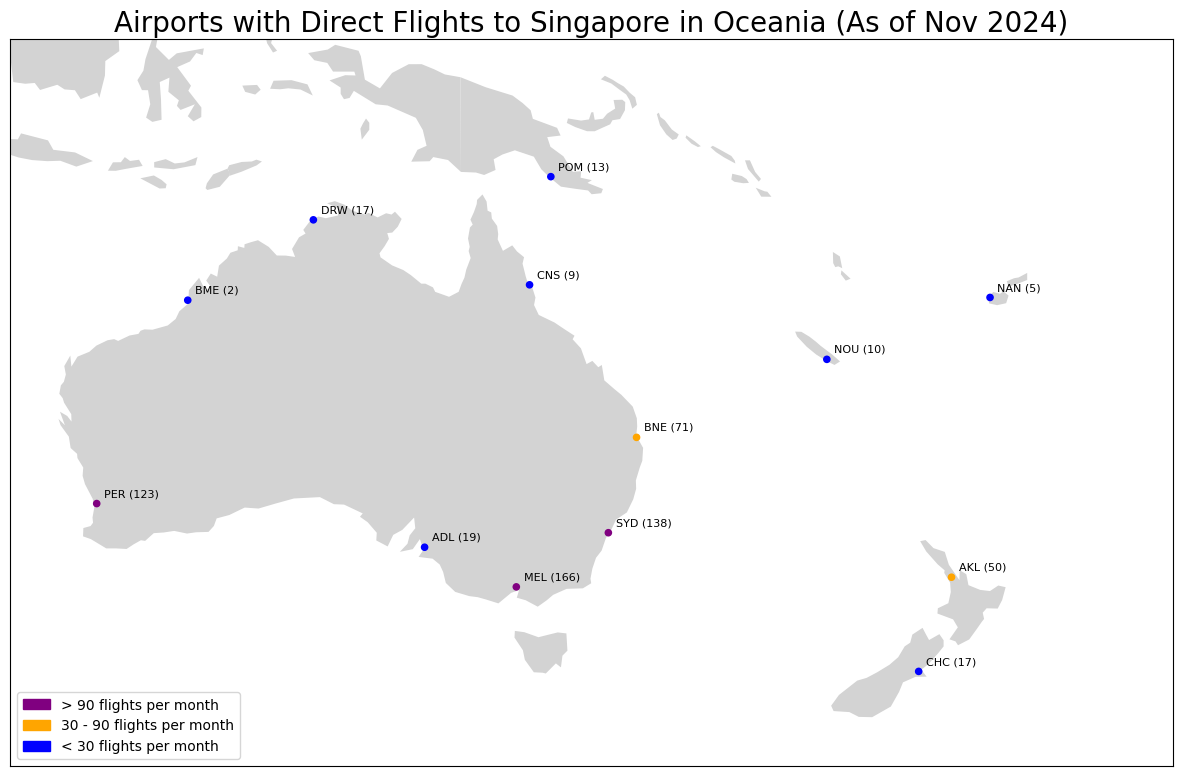

In [17]:
oceania_countries = [
    'Australia', 'New Zealand', 'Papua New Guinea', 'Fiji', 'New Caledonia'
]
flights_df_oceania= flights_df[flights_df['country'].isin(oceania_countries)]

merged_df = pd.merge(flights_df_oceania, airports_df, left_on='airport_code', right_on='iata')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf['color'] = gdf['total_flights'].apply(lambda x: 'purple' if x > 90 else ('orange' if x >= 30 else 'blue'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=20,
    legend=False
)

purple_patch = mpatches.Patch(color='purple', label='> 90 flights per month')
orange_patch = mpatches.Patch(color='orange', label='30 - 90 flights per month')
blue_patch = mpatches.Patch(color='blue', label='< 30 flights per month')
plt.legend(handles=[purple_patch, orange_patch, blue_patch], loc='lower left')

# Add text labels for each airport
for idx, row in gdf.iterrows():
    lon_offset = 0.5
    lat_offset = 0.5
    airport_label = f"{row['airport_code']} ({row['total_flights']})"
    ax.text(
        row['longitude'] + lon_offset,
        row['latitude'] + lat_offset,
        airport_label,
        fontsize=8,
        ha='left'
    )

# Set the zoom to Oceania
ax.set_xlim(110, 190)
ax.set_ylim(-50, 0)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Airports with Direct Flights to Singapore in Oceania (As of Nov 2024)', fontsize=20)

plt.show()

europe

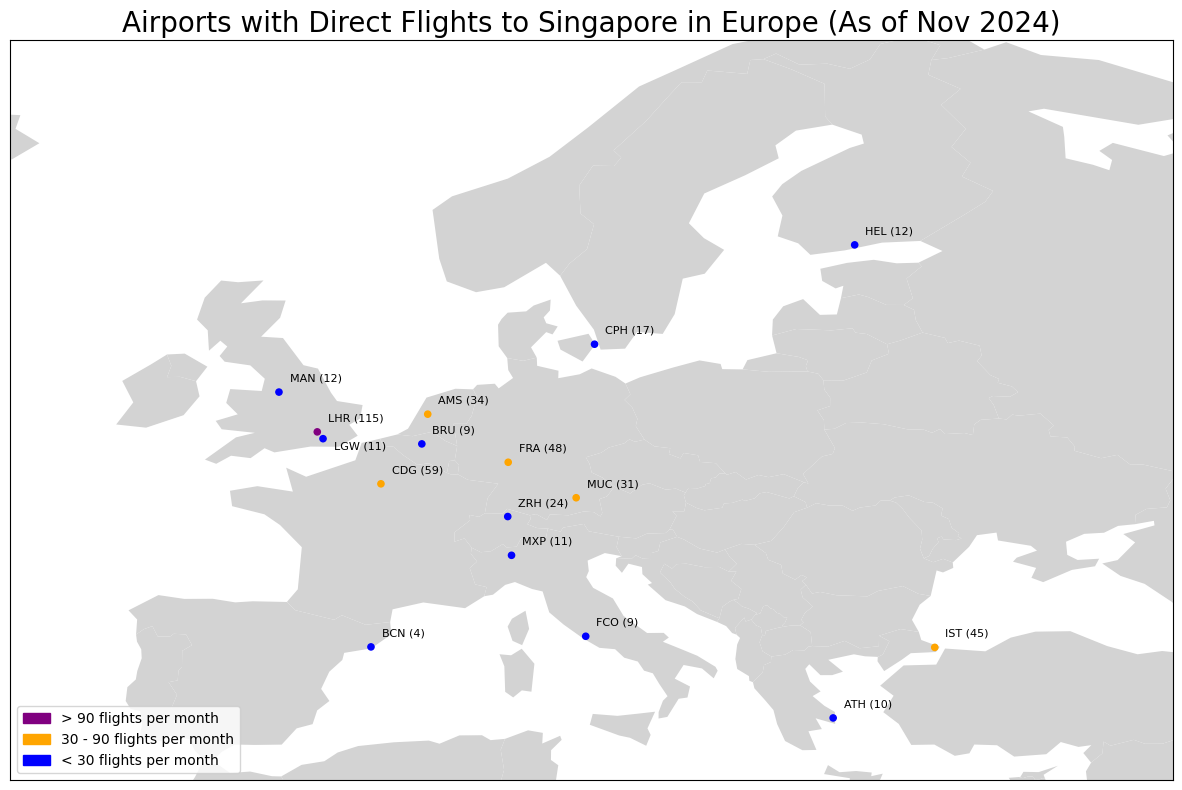

In [18]:
european_countries = [
    'Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 
    'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 
    'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 
    'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kazakhstan', 'Kosovo', 'Latvia', 
    'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 
    'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 
    'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 
    'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom', 'Vatican City', 'Turkey'
]
flights_df_european = flights_df[flights_df['country'].isin(european_countries)]

merged_df = pd.merge(flights_df_european, airports_df, left_on='airport_code', right_on='iata')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf['color'] = gdf['total_flights'].apply(lambda x: 'purple' if x > 90 else ('orange' if x >= 30 else 'blue'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=20,
    legend=False
)

purple_patch = mpatches.Patch(color='purple', label='> 90 flights per month')
orange_patch = mpatches.Patch(color='orange', label='30 - 90 flights per month')
blue_patch = mpatches.Patch(color='blue', label='< 30 flights per month')
plt.legend(handles=[purple_patch, orange_patch, blue_patch], loc='lower left')

# Add text labels for each airport
for idx, row in gdf.iterrows():
    lon_offset = 0.5
    lat_offset = 0.5
    airport_label = f"{row['airport_code']} ({row['total_flights']})"
    if row['airport_code'] == 'LGW':
        lat_offset = -0.5
    ax.text(
        row['longitude'] + lon_offset,
        row['latitude'] + lat_offset,
        airport_label,
        fontsize=8,
        ha='left'
    )

# Set the zoom to Europe
ax.set_xlim(-15, 40)
ax.set_ylim(35, 70)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Airports with Direct Flights to Singapore in Europe (As of Nov 2024)', fontsize=20)

plt.show()

south asia

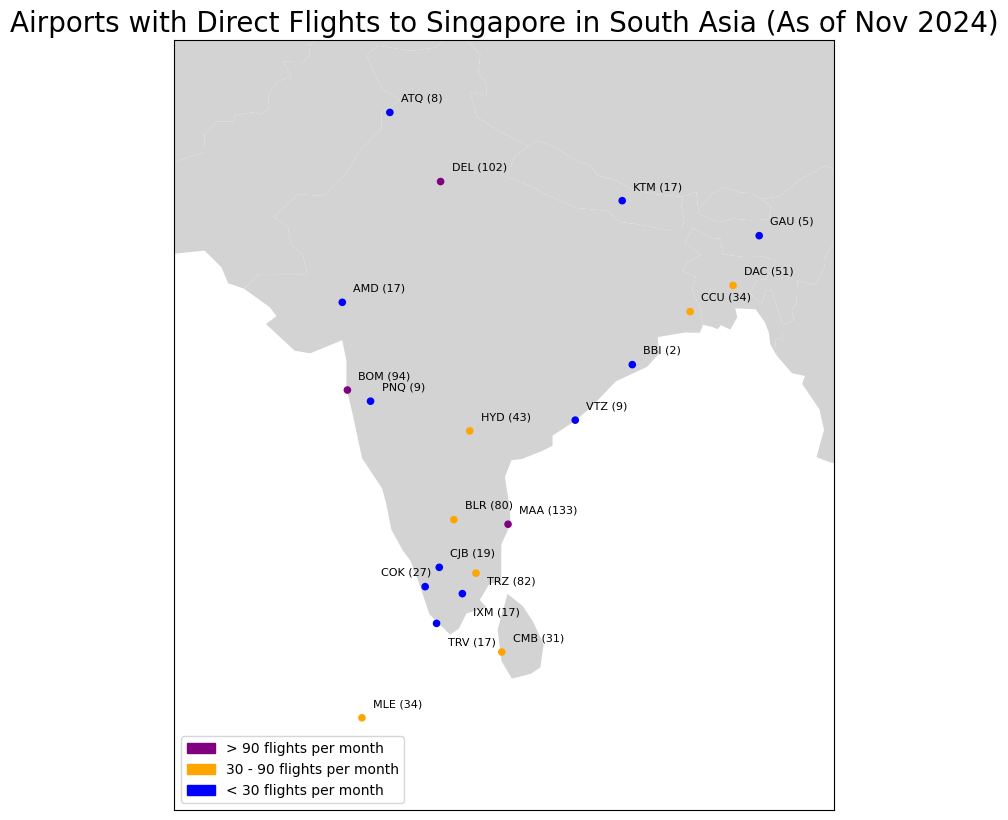

In [19]:
sa_countries = [
    'India', 'Bangladesh', 'Nepal', 'Bhutan', 'Sri Lanka', 'Maldives'
]
flights_df_sa = flights_df[flights_df['country'].isin(sa_countries)]

merged_df = pd.merge(flights_df_sa, airports_df, left_on='airport_code', right_on='iata')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf['color'] = gdf['total_flights'].apply(lambda x: 'purple' if x > 90 else ('orange' if x >= 30 else 'blue'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=20,
    legend=False
)

purple_patch = mpatches.Patch(color='purple', label='> 90 flights per month')
orange_patch = mpatches.Patch(color='orange', label='30 - 90 flights per month')
blue_patch = mpatches.Patch(color='blue', label='< 30 flights per month')
plt.legend(handles=[purple_patch, orange_patch, blue_patch], loc='lower left')

# Add text labels for each airport
for idx, row in gdf.iterrows():
    lon_offset = 0.5
    lat_offset = 0.5
    airport_label = f"{row['airport_code']} ({row['total_flights']})"
    if row['airport_code'] == 'COK':
        lon_offset = -2
    if row['airport_code'] == 'TRV':
        lat_offset = -1
    if row['airport_code'] == 'IXM':
        lat_offset = -1
    if row['airport_code'] == 'TRZ':
        lat_offset = -0.5
    ax.text(
        row['longitude'] + lon_offset, 
        row['latitude'] + lat_offset,
        airport_label,
        fontsize=8,
        ha='left'
    )

# Set the zoom to South Asia
ax.set_xlim(65, 95)
ax.set_ylim(0, 35)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Airports with Direct Flights to Singapore in South Asia (As of Nov 2024)', fontsize=20)

plt.show()

middle east and africa

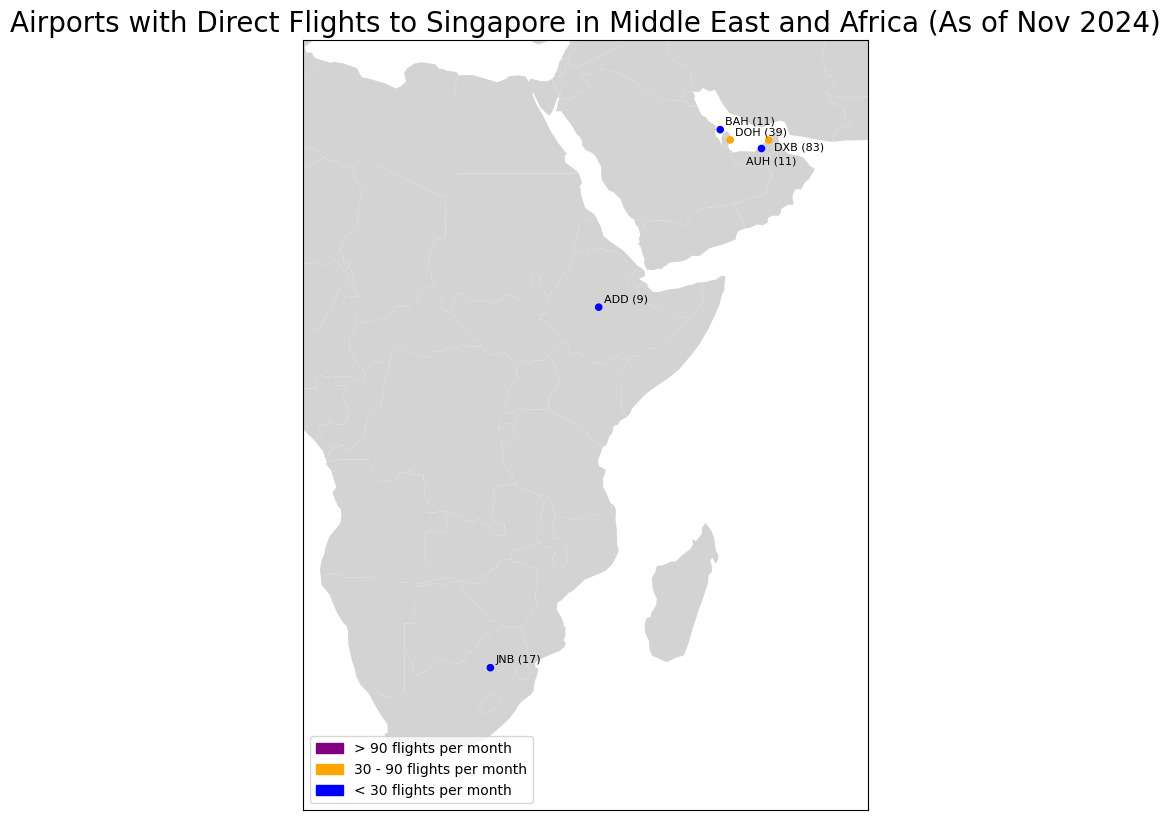

In [20]:
me_countries = [
    'United Arab Emirates', 'Qatar', 'Bahrain', 'Ethiopia', 'South Africa'
]
flights_df_me = flights_df[flights_df['country'].isin(me_countries)]

merged_df = pd.merge(flights_df_me, airports_df, left_on='airport_code', right_on='iata')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf['color'] = gdf['total_flights'].apply(lambda x: 'purple' if x > 90 else ('orange' if x >= 30 else 'blue'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=20,
    legend=False
)

purple_patch = mpatches.Patch(color='purple', label='> 90 flights per month')
orange_patch = mpatches.Patch(color='orange', label='30 - 90 flights per month')
blue_patch = mpatches.Patch(color='blue', label='< 30 flights per month')
plt.legend(handles=[purple_patch, orange_patch, blue_patch], loc='lower left')

# Add text labels for each airport
for idx, row in gdf.iterrows():
    lon_offset = 0.5
    lat_offset = 0.5
    airport_label = f"{row['airport_code']} ({row['total_flights']})"
    if row['airport_code'] == 'AUH':
        lat_offset = -1.5
        lon_offset = -1.5
    if row['airport_code'] == 'DXB':
        lat_offset = -1
    ax.text(
        row['longitude'] + lon_offset,
        row['latitude'] + lat_offset,
        airport_label,
        fontsize=8,
        ha='left'
    )

# Set the zoom to Middle East and Africa
ax.set_xlim(10, 65)
ax.set_ylim(-40, 35)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Airports with Direct Flights to Singapore in Middle East and Africa (As of Nov 2024)', fontsize=20)

plt.show()

north america

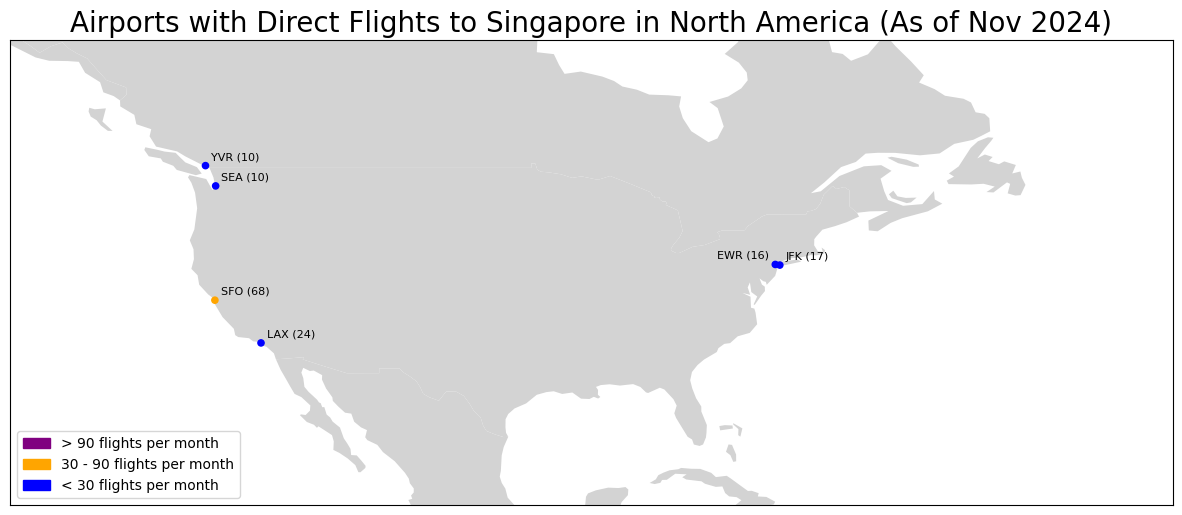

In [21]:
na_countries = [
    'United States', 'Canada'
]
flights_df_na = flights_df[flights_df['country'].isin(na_countries)]

merged_df = pd.merge(flights_df_na, airports_df, left_on='airport_code', right_on='iata')
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf['color'] = gdf['total_flights'].apply(lambda x: 'purple' if x > 90 else ('orange' if x >= 30 else 'blue'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(
    ax=ax,
    color=gdf['color'],
    markersize=20,
    legend=False
)

purple_patch = mpatches.Patch(color='purple', label='> 90 flights per month')
orange_patch = mpatches.Patch(color='orange', label='30 - 90 flights per month')
blue_patch = mpatches.Patch(color='blue', label='< 30 flights per month')
plt.legend(handles=[purple_patch, orange_patch, blue_patch], loc='lower left')

# Add text labels for each airport
for idx, row in gdf.iterrows():
    lon_offset = 0.5
    lat_offset = 0.5
    airport_label = f"{row['airport_code']} ({row['total_flights']})"
    if row['airport_code'] == 'EWR':
        lon_offset = -5

    ax.text(
        row['longitude'] + lon_offset,
        row['latitude'] + lat_offset,
        airport_label,
        fontsize=8,
        ha='left'
    )

# Set the zoom to North America
ax.set_xlim(-140, -40)
ax.set_ylim(20, 60)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Airports with Direct Flights to Singapore in North America (As of Nov 2024)', fontsize=20)

plt.show()